<a href="https://colab.research.google.com/github/koidula/POSII/blob/main/%D0%9B%D0%B0%D0%BD%D0%B4%D1%8B%D0%B7%D0%B8%D0%BD_%D0%9F%D0%9E%D0%A1%D0%98%D0%98_%D0%9B%D0%A02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.



## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [42]:
%pylab inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['median']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [43]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР2/Train_rev1.csv')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [44]:
data.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [45]:
print(data.shape)

(244768, 12)


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

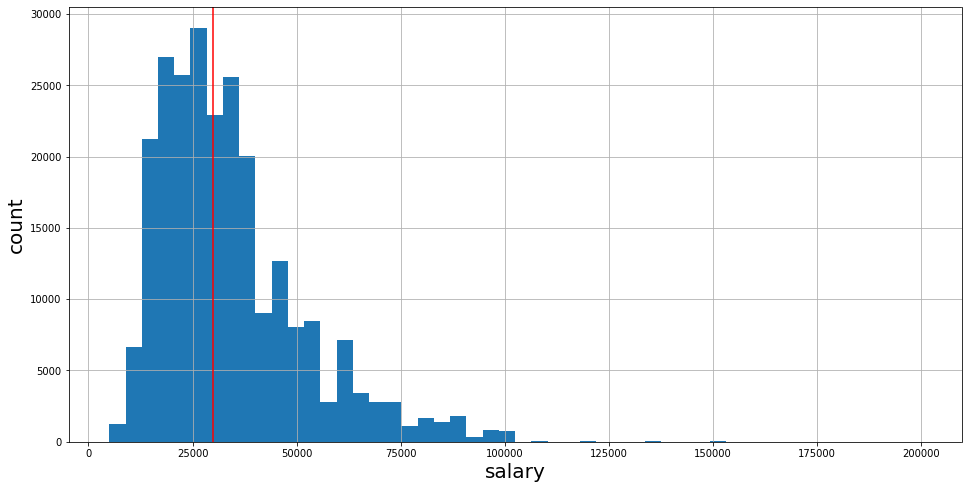

In [46]:
# гистограмма зп
median = np.median(data['SalaryNormalized'])

figsize(16,8)
plt.hist(data['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [47]:
data['SalaryNormalized'] = (data['SalaryNormalized'] > median).astype(int)
data.drop('SalaryRaw', axis=1, inplace=True)
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [49]:
'''
random_state - сид для псевдослучайного генератора
недетерминированные операции на одних и тех же данных с одним и тем же random_state дают один и тот же результат
'''

from sklearn.model_selection import train_test_split

Y = data['SalaryNormalized']
X = data.drop('SalaryNormalized', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Вывод размерностей полученных выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер контрольной выборки:", X_test.shape)

Размер обучающей выборки: (171337, 10)
Размер контрольной выборки: (73431, 10)


In [9]:
#Табличное представление обучающей выборки дата
X_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
241453,72676065,Business Development Executive ****k plus bonus,Business Development Executive Dudley Permanen...,"Dudley, West Midlands (County) West Midlands (...",UK,NaN,permanent,Anderson Scott Solutions,Sales Jobs,totaljobs.com
169520,71341050,English Teacher,"English Teacher Permanent, Fulltime contract ...",Avon,Avon,full_time,contract,ITN Mark Education Bristol,Teaching Jobs,jobsineducation.co.uk
136661,70336585,EMEA Customer Service Project Coordinator,Excellent opportunity to join a successful glo...,Oxford,Oxford,full_time,NaN,Bluestream Recruitment,Customer Services Jobs,careerbuilder.com
125435,69992269,Administrator / Receptionist,Acting as a recruitment business on behalf of ...,Leeds West Yorkshire Yorkshire,Leeds,NaN,contract,Taskmaster,Admin Jobs,totaljobs.com
192568,71760157,Business Analyst / Product Owner to ****k,Business Analyst / Product Owner This is an ex...,London South East,South East London,NaN,permanent,The Industry Club,IT Jobs,cwjobs.co.uk


In [83]:
#Табличное представление меток
y_train.head()

241453    0
169520    0
136661    0
125435    0
192568    1
Name: SalaryNormalized, dtype: int64

## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.



#### 2. Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [84]:
#функция объединяет все текстовые столбцы в один текстовый 
#столбец и заполняет пропущенные значения строковой константой "nan"
def get_text_col(x):
    cat_features_mask = (x.dtypes == "object").values
    data_str = x[x.columns[cat_features_mask]]
    data_str.fillna('nan', inplace=True)
    text = data_str[data_str.columns[0]]
    data_str.columns
    for col in data_str.columns[1:]:
        text += ' ' + data_str[col]
    return text
    
text_train = get_text_col(X_train)
text_test = get_text_col(X_test)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
fit_vect = vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [85]:
print("Пример X_test:")
print(X_test[0])

Пример X_test:
  (0, 1111)	1
  (0, 1121)	1
  (0, 1213)	1
  (0, 2236)	1
  (0, 2237)	1
  (0, 5079)	5
  (0, 5427)	1
  (0, 5764)	1
  (0, 8080)	1
  (0, 8644)	1
  (0, 8681)	1
  (0, 9091)	1
  (0, 9593)	1
  (0, 9916)	13
  (0, 12190)	4
  (0, 12192)	1
  (0, 12868)	1
  (0, 14693)	2
  (0, 15640)	1
  (0, 15834)	1
  (0, 16245)	1
  (0, 16726)	1
  (0, 17257)	2
  (0, 17409)	1
  (0, 17675)	1
  :	:
  (0, 155254)	10
  (0, 155938)	2
  (0, 156233)	1
  (0, 156620)	1
  (0, 156697)	1
  (0, 157692)	1
  (0, 158071)	1
  (0, 158654)	1
  (0, 159886)	1
  (0, 160211)	1
  (0, 161601)	1
  (0, 161898)	1
  (0, 162865)	2
  (0, 163277)	2
  (0, 163601)	2
  (0, 163986)	1
  (0, 164423)	1
  (0, 164619)	6
  (0, 165335)	5
  (0, 165475)	1
  (0, 165849)	3
  (0, 165906)	2
  (0, 167205)	2
  (0, 168150)	5
  (0, 168226)	1


#### 3. Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [86]:
from sklearn.linear_model import LogisticRegression

# создание объекта LogisticRegression с параметрами по умолчанию
lr = LogisticRegression()

# обучение модели на обучающей выборке
lr.fit(X_train, y_train)


LogisticRegression()

In [87]:
!pip install vowpalwabbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
#придется использовать vw обернутый в Python и совместимый с sklearn, чтобы вызывать было проще в рамках ipynb

In [89]:
from vowpalwabbit.sklearn import VWClassifier
logreg_vw = VWClassifier(loss_function='logistic', invert_hash = '/content/readable_model.vw')
logreg_vw.fit(X_train, y_train)
logreg_vw.save('/content/readable_model.vw')

#### 4. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [90]:
#Предикты VW и SKL
y_pred_sklearn = lr.predict(X_test)
y_pred_vw = logreg_vw.predict(X_test)

In [91]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

#Метрики SKL
roc_auc_sklearn = roc_auc_score(y_test, y_pred_sklearn)
f1_sklearn = f1_score(y_test, y_pred_sklearn)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)

#Метрики VW
roc_auc_vw = roc_auc_score(y_test, y_pred_vw)
f1_vw = f1_score(y_test, y_pred_vw)
cm_vw = confusion_matrix(y_test, y_pred_vw)

print('Модель из sklearn:')
print('ROC-AUC:', roc_auc_sklearn)
print('F-мера:', f1_sklearn)
print('Матрица ошибок:\n', cm_sklearn)
print('-------------------------------------')
print('Модель из Vowpal Wabbit:')
print('ROC-AUC:', roc_auc_vw)
print('F-мера:', f1_vw)
print('Матрица ошибок:\n', cm_vw)

Модель из sklearn:
ROC-AUC: 0.8594788280536557
F-мера: 0.8548332582244255
Матрица ошибок:
 [[32773  5167]
 [ 5141 30350]]
-------------------------------------
Модель из Vowpal Wabbit:
ROC-AUC: 0.8678451542512422
F-мера: 0.8632862101075086
Матрица ошибок:
 [[33147  4793]
 [ 4897 30594]]


#### 5. Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [111]:
#Отсортируем коэффициенты в модели lr (SKL)
indexes = np.argsort([abs(i) for i in lr.coef_])[0]  #168740

#Вызов слов из векторайзера
columns = vectorizer.get_feature_names_out() #168740

#Размер ТОПа
top_size = 10

print('Слова с наименьшим влиянием на значение целевой переменной:')
for i in range(0,top_size):
    print(columns[indexes[i]], lr.coef_[0][indexes[i]])
print(f'\n')     
print('Слова с наибольшим влиянием на значение целевой переменной:')
for i in range(len(indexes) - top_size,len(indexes)):
    print(columns[indexes[i]], lr.coef_[0][indexes[i]])


Слова с наименьшим влиянием на значение целевой переменной:
ashfordhodges -1.4451620713508236e-08
competantly 2.3195926266796202e-07
toclients 2.339989180121781e-07
assi 4.826808914210177e-07
yourcv 5.372624691151287e-07
infobase 5.883579342860437e-07
synch -6.716897969382083e-07
contractural -1.0038475593765138e-06
wd6 1.213484712176121e-06
barod -1.2309208835702082e-06


Слова с наибольшим влиянием на значение целевой переменной:
principal 0.563950931535959
graduate -0.5660215352676077
myukjobs -0.5981614519080241
theladders 0.6008334899072282
technojobs 0.6401648211234885
assistant -0.6596243272072834
locum 0.771574218959991
nvq -0.7938502548698207
jobcentre -1.0837234373900189
optometrist 1.2180182196628153


#### 6. Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [105]:
vwarr = feature_weights #1,262144 shape
skl = lr.coef_ #1,168740 shape

In [124]:
feature_weights_raw = logreg_vw.get_coefs()
feature_weights = feature_weights_raw.toarray() # фишка, тк get_coefs() отдает csr_matrix, пуляем ее в numpy array
feature_weights = feature_weights[:,0:168740] #еще одна фишка, тк sklearn реализация возвращает массив размерностью 1,262144

indexes = np.argsort([abs(i) for i in feature_weights[0]]) #262144


#Вызов слов из векторайзера
columns = vectorizer.get_feature_names_out() #168740

#Размер ТОПа
top_size = 10

print('Слова с наименьшим влиянием на значение целевой переменной:')
for i in range(0,top_size):
    print(columns[indexes[i]], feature_weights[0][indexes[i]])
print(f'\n')     
print('Слова с наибольшим влиянием на значение целевой переменной:')
for i in range(len(indexes) - top_size,len(indexes)):
    print(columns[indexes[i]], feature_weights[0][indexes[i]])



Слова с наименьшим влиянием на значение целевой переменной:
dormitories 0.0
unplugging 0.0
occurances 0.0
splashbacks 0.0
freshners 0.0
supe 0.0
shampoodry 0.0
taffs -1.169741153717041e-06
advantageousall -5.446374416351318e-06
gloucestershire -5.734144451707834e-06


Слова с наибольшим влиянием на значение целевой переменной:
administrator_job -0.9777079820632935
ryanh 0.9842252135276794
infochasemedical 0.9971089959144592
assistantaccountant_job -1.0120567083358765
findababysitter -1.0203423500061035
nijobfinder -1.071933627128601
jobsitnmark -1.0733424425125122
efinancialcareers 1.1133224964141846
oilandgasjobsearch 1.2838788032531738
theladders 2.5484402179718018


## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.



#### 7. Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

TF (term frequency — частота слова) — отношение числа вхождений некоторого слова к общему числу слов документа. Таким образом, оценивается важность слова ti  в пределах отдельного документа.

IDF (inverse document frequency — обратная частота документа) — инверсия частоты, с которой некоторое слово встречается в документах коллекции. Учёт IDF уменьшает вес широкоупотребительных слов. Для каждого уникального слова в пределах конкретной коллекции документов существует только одно значение IDF.


In [129]:
#text_train
#text_test
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer2 = TfidfVectorizer()
_ = vectorizer2.fit(text_train)

X_train2 = vectorizer2.transform(text_train)
X_test2 = vectorizer2.transform(text_test)

#### 8.  Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [130]:
lr2 = linear_model.LogisticRegression()
lr2.fit(X_train2, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


LogisticRegression()

In [132]:
logreg_vw2 = VWClassifier(loss_function='logistic', invert_hash = '/content/readable_model2.vw')
logreg_vw2.fit(X_train2, y_train)
logreg_vw2.save('/content/readable_model2.vw')

In [133]:
#Предикты VW и SKL
y_pred_sklearn2 = lr2.predict(X_test2)
y_pred_vw2 = logreg_vw2.predict(X_test2)

#### 9. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [135]:
#Метрики SKL
roc_auc_sklearn2 = roc_auc_score(y_test, y_pred_sklearn2)
f1_sklearn2 = f1_score(y_test, y_pred_sklearn2)
cm_sklearn2 = confusion_matrix(y_test, y_pred_sklearn2)

#Метрики VW
roc_auc_vw2 = roc_auc_score(y_test, y_pred_vw2)
f1_vw2 = f1_score(y_test, y_pred_vw2)
cm_vw2 = confusion_matrix(y_test, y_pred_vw2)

print('Модель из sklearn:')
print('ROC-AUC:', roc_auc_sklearn2)
print('F-мера:', f1_sklearn2)
print('Матрица ошибок:\n', cm_sklearn2)
print('-------------------------------------')
print('Модель из Vowpal Wabbit:')
print('ROC-AUC:', roc_auc_vw2)
print('F-мера:', f1_vw2)
print('Матрица ошибок:\n', cm_vw2)

Модель из sklearn:
ROC-AUC: 0.8692054046622733
F-мера: 0.8652418573974544
Матрица ошибок:
 [[32999  4941]
 [ 4662 30829]]
-------------------------------------
Модель из Vowpal Wabbit:
ROC-AUC: 0.8733090770582553
F-мера: 0.8695883729730487
Матрица ошибок:
 [[33103  4837]
 [ 4468 31023]]


#### 10. Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:
В случае логистической регрессии значение auc-roc и f1_score уменьшилось, что может говорить о том, что в данном конкретном примере применение TFIDF векторизатора ухудшило результаты модели

In [137]:
print("Разница моделей sklearn:", roc_auc_sklearn - roc_auc_sklearn2, f1_sklearn - f1_sklearn2)
print("Разница моделей vw:", roc_auc_vw - roc_auc_vw2, f1_vw - f1_vw2)

Разница моделей sklearn: -0.009726576608617532 -0.010408599173028943
Разница моделей vw: -0.005463922807013133 -0.006302162865540084


#### 11.  Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [138]:
#Отсортируем коэффициенты в модели lr (SKL)
indexes = np.argsort([abs(i) for i in lr2.coef_])[0]  #168740

#Вызов слов из векторайзера
columns = vectorizer2.get_feature_names_out() #168740

#Размер ТОПа
top_size = 10

print('Слова с наименьшим влиянием на значение целевой переменной:')
for i in range(0,top_size):
    print(columns[indexes[i]], lr2.coef_[0][indexes[i]])
print(f'\n')     
print('Слова с наибольшим влиянием на значение целевой переменной:')
for i in range(len(indexes) - top_size,len(indexes)):
    print(columns[indexes[i]], lr2.coef_[0][indexes[i]])

Слова с наименьшим влиянием на значение целевой переменной:
outoftown -4.613197753759758e-06
mauborgne -5.039494865954669e-06
disbursed -6.235861973338256e-06
wellmannered 8.333949760180864e-06
goodfellow 1.1332445223555825e-05
2billion 1.433404153760922e-05
petaid 1.4811995213718294e-05
broke 1.6583110707396077e-05
suppor -1.8878621966325012e-05
seafield 2.1462396950882936e-05


Слова с наибольшим влиянием на значение целевой переменной:
london 6.429007296222638
head 7.17295238250566
senior 7.482500676219683
jobcentre -7.52372297096958
junior -7.842554325055648
director 7.907590030527782
manager 7.921845287553211
optometrist 8.904035758889725
graduate -10.151277442552884
assistant -11.032236903307236


#### 12. Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [139]:
feature_weights_raw2 = logreg_vw2.get_coefs()
feature_weights2 = feature_weights_raw2.toarray() # фишка, тк get_coefs() отдает csr_matrix, пуляем ее в numpy array
feature_weights2 = feature_weights2[:,0:168740] #еще одна фишка, тк sklearn реализация возвращает массив размерностью 1,262144

indexes2 = np.argsort([abs(i) for i in feature_weights2[0]]) #262144


#Вызов слов из векторайзера
columns = vectorizer2.get_feature_names_out() #168740

#Размер ТОПа
top_size = 10

print('Слова с наименьшим влиянием на значение целевой переменной:')
for i in range(0,top_size):
    print(columns[indexes2[i]], feature_weights2[0][indexes2[i]])
print(f'\n')     
print('Слова с наибольшим влиянием на значение целевой переменной:')
for i in range(len(indexes2) - top_size,len(indexes2)):
    print(columns[indexes2[i]], feature_weights2[0][indexes2[i]])

Слова с наименьшим влиянием на значение целевой переменной:
judd -4.678964614868164e-06
kk -5.844980478286743e-06
arndale 5.310773849487305e-05
readman 5.4717063903808594e-05
readmanrobertwalters 5.4717063903808594e-05
andrewmra -5.84721565246582e-05
coordinators 8.13901424407959e-05
jjfox 0.0001501869410276413
paining -0.00015741586685180664
holidaysare 0.00023001432418823242


Слова с наибольшим влиянием на значение целевой переменной:
spoton -8.52326488494873
spkcfl -8.625574111938477
_6 -8.625574111938477
hearingcareflamehealth -8.706862449645996
m883221 -8.859704971313477
_8 -8.859704971313477
navisionjobs 9.178306579589844
drenched 11.778279304504395
yearscoring -12.776012420654297
theladders 15.840387344360352


## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [50]:
# вычисляем количество строк в датафрейме
X_rows = len(X)
Y_rows = len(Y)
# вычисляем индекс строки, после которой нужно отделить часть датафрейма
split_index_X = X_rows // 25 #10 дропается, 50 плохие результаты |||||||| 
split_index_Y = Y_rows // 25
# отделяем первую половину строк в отдельный датафрейм
X = X.loc[:split_index_X-1]
Y = Y.loc[:split_index_Y-1]


# проверяем размеры полученных датафреймов
print(f"Размер тренировочного датафрейма: {X.shape}")
print(f"Размер тестового датафрейма: {Y.shape}")


Размер тренировочного датафрейма: (9790, 10)
Размер тестового датафрейма: (9790,)


In [60]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.30, random_state=42)

# Заполнение пропущенных значений строкой " "
X_train3['Title'].fillna(" ", inplace=True)
X_train3['FullDescription'].fillna(" ", inplace=True)
X_test3['Title'].fillna(" ", inplace=True)
X_test3['FullDescription'].fillna(" ", inplace=True)

#Объединим признаки
X_train3['text'] = X_train3['Title'] + ' ' + X_train3['FullDescription']
X_test3['text'] = X_test3['Title'] + ' ' + X_test3['FullDescription']

#Отбросим ненужные уже столбцы
X_train3 = X_train3.drop(['Title', 'FullDescription'], axis = 1)
X_test3 = X_test3.drop(['Title', 'FullDescription'], axis = 1)

from sklearn.feature_extraction.text import TfidfVectorizer

# Создаем экземпляр TfidfVectorizer
vectorizer = TfidfVectorizer()

# Применяем векторизацию на контрольной и на обучающей выборке
train_tfidf = vectorizer.fit_transform(X_train3['text'])
test_tfidf = vectorizer.transform(X_test3['text'])

X_train3 = X_train3.drop(['text'], axis=1)
X_test3 = X_test3.drop(['text'], axis=1)

In [52]:
print(X_train3.columns)

Index(['Id', 'LocationRaw', 'LocationNormalized', 'ContractType',
       'ContractTime', 'Company', 'Category', 'SourceName'],
      dtype='object')


#### 14. Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [53]:
# выбрать только те столбцы, которые нужно закодировать
cols_to_encode = X_train3.columns.difference(['text'])

from sklearn.preprocessing import LabelEncoder as le

enc = le()
for col in cols_to_encode:
    X_train3[col] = enc.fit_transform(X_train3[col])

#Аналогично для test
for col in cols_to_encode:
    X_test3[col] = enc.fit_transform(X_test3[col])


X_train3.head()

,Id,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
4635,3229,1756,714,2,2,695,5,4
3777,2636,1667,694,2,1,41,12,15
7018,4916,979,397,2,0,963,19,3
1152,793,842,694,0,2,965,11,12
5137,3574,1032,419,2,2,436,22,4


In [54]:
del data

In [55]:
import gc
gc.collect()

6244

In [56]:
#print(X_train3.shape)
train_tfidf = pd.DataFrame(train_tfidf.toarray())
#print(train_tfidf.shape)
# Пришлось дропнуть индексы, иначе размер растет
X_train3 = pd.concat([X_train3.reset_index(drop=True), train_tfidf.reset_index(drop=True)], axis = 1) 
#print(X_train3.shape)
gc.collect()
test_tfidf = pd.DataFrame(test_tfidf.toarray())
X_test3 = pd.concat([X_test3.reset_index(drop=True), test_tfidf.reset_index(drop=True)], axis = 1)

In [57]:
X_train3.head()

,Id,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,0,1,...,23597,23598,23599,23600,23601,23602,23603,23604,23605,23606
0,3229,1756,714,2,2,695,5,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2636,1667,694,2,1,41,12,15,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4916,979,397,2,0,963,19,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793,842,694,0,2,965,11,12,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3574,1032,419,2,2,436,22,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

X_train3.columns = X_train3.columns.astype(str)
# Создание экземпляра преобразователя
imputer = SimpleImputer(strategy='mean')
# Применение преобразователя к данным
X_train3_learn_imp = imputer.fit_transform(X_train3)

#Обучение
lr3 = LogisticRegression()
lr3.fit(X_train3_learn_imp, y_train3)



''''''
X_test3.columns = X_test3.columns.astype(str)
# Применение преобразователя к данным
X_test3_learn_imp = imputer.fit_transform(X_test3)


#Предикты SKL
y_pred_sklearn3 = lr3.predict(X_test3_learn_imp)

#Метрики SKL
roc_auc_sklearn3 = roc_auc_score(y_test3, y_pred_sklearn3)
f1_sklearn3 = f1_score(y_test3, y_pred_sklearn3)
cm_sklearn3 = confusion_matrix(y_test3, y_pred_sklearn3)

print('Модель из sklearn:')
print('ROC-AUC:', roc_auc_sklearn3)
print('F-мера:', f1_sklearn3)
print('Матрица ошибок:\n', cm_sklearn3)

Модель из sklearn:
ROC-AUC: 0.5919414268470873
F-мера: 0.39717978848413626
Матрица ошибок:
 [[1573  176]
 [ 850  338]]


In [59]:
del X_train3, X_test3

#### One-Hot Encoder не получился

In [15]:
from sklearn.preprocessing import OneHotEncoder as ohe

# Отбираем столбцы для кодирования
cols_to_encode = X_train3.columns.difference(['text'])

# Создаем объект OneHotEncoder
enc = ohe(handle_unknown='ignore', sparse=False)

# Обучаем OneHotEncoder и кодируем столбцы
encoded_cols = enc.fit_transform(X_train3[cols_to_encode])
indicies = encoded_cols.argmax(axis=1)

# Создаем dataframe из закодированных столбцов
encoded_df = pd.DataFrame(encoded_cols, columns=X_train3[cols_to_encode].columns)

# Объединяем закодированные столбцы с исходным dataframe
df_encoded = pd.concat([X_train3.drop(cols_to_encode, axis=1), encoded_df], axis=1)

ValueError: ignored

In [11]:
df_encoded.head(1)

,text,Category_Accounting & Finance Jobs,Category_Admin Jobs,Category_Charity & Voluntary Jobs,Category_Consultancy Jobs,Category_Creative & Design Jobs,Category_Customer Services Jobs,Category_Domestic help & Cleaning Jobs,"Category_Energy, Oil & Gas Jobs",Category_Engineering Jobs,...,SourceName_theitjobboard.co.uk,SourceName_theladders.co.uk,SourceName_tntjobs.co.uk,SourceName_totaljobs.com,SourceName_traveljobsearch.com,SourceName_uksport.gov.uk,SourceName_ukstaffsearch.com,SourceName_wileyjobnetwork.com,SourceName_workthing.com,SourceName_zartis.com
0,Engineering Systems Analyst Engineering System...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 15. Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

In [66]:
del X, Y,

In [67]:
# выбрать только те столбцы, которые нужно закодировать
cols_to_encode = X_train3.columns.difference(['text'])

from sklearn.feature_extraction.text import CountVectorizer 

# Создаем объект CountVectorizer и кодируем столбцы
cv = CountVectorizer()
encoded_cols = cv.fit_transform(X_train3[cols_to_encode])

# Создаем dataframe из закодированных столбцов
encoded_df = pd.DataFrame(encoded_cols.toarray(), columns=cv.get_feature_names_out())
del encoded_cols

# Объединяем закодированные столбцы с исходным dataframe
X_train3 = pd.concat([X_train3.drop(cols_to_encode, axis=1).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
del encoded_df

#Аналог для X_test3
encoded_cols = cv.fit_transform(X_test3[cols_to_encode])
encoded_df = pd.DataFrame(encoded_cols.toarray(), columns=cv.get_feature_names_out())
del encoded_cols
X_test3 = pd.concat([X_test3.drop(cols_to_encode, axis=1).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
del encoded_df

X_train3.head()

,category,company,contracttime,contracttype,id,locationnormalized,locationraw,sourcename
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
#print(X_train3.shape)
train_tfidf = pd.DataFrame(train_tfidf.toarray())
#print(train_tfidf.shape)
# Пришлось дропнуть индексы, иначе размер растет
X_train3 = pd.concat([X_train3.reset_index(drop=True), train_tfidf.reset_index(drop=True)], axis = 1) 
#print(X_train3.shape)
test_tfidf = pd.DataFrame(test_tfidf.toarray())
X_test3 = pd.concat([X_test3.reset_index(drop=True), test_tfidf.reset_index(drop=True)], axis = 1)


In [71]:
del test_tfidf, train_tfidf

In [72]:
import gc
gc.collect()

25

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

X_train3.columns = X_train3.columns.astype(str)
#Тут стратегия с импутером не получилась
X_train3.fillna(0, inplace=True)

#Обучение
lr3 = LogisticRegression()
lr3.fit(X_train3, y_train3)



LogisticRegression()

In [74]:
X_test3.columns = X_test3.columns.astype(str)
# Применение преобразователя к данным
X_test3.fillna(0, inplace=True)


#Предикты SKL
y_pred_sklearn3 = lr3.predict(X_test3)

#Метрики SKL
roc_auc_sklearn3_2 = roc_auc_score(y_test3, y_pred_sklearn3)
f1_sklearn3_2 = f1_score(y_test3, y_pred_sklearn3)
cm_sklearn3_2 = confusion_matrix(y_test3, y_pred_sklearn3)

print('Модель из sklearn:')
print('ROC-AUC:', roc_auc_sklearn3_2)
print('F-мера:', f1_sklearn3_2)
print('Матрица ошибок:\n', cm_sklearn3_2)

Модель из sklearn:
ROC-AUC: 0.8331427482370878
F-мера: 0.8010403120936281
Матрица ошибок:
 [[1554  195]
 [ 264  924]]


#### 16.  Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**
В связи с тем, что вместо One-Hot Encoding использовался LE, а также с тем, что выборка значительно сокращается по сравнению с исходной, результаты модели, обученной на наборе с примененным кодированием заметно лучше.

In [75]:
print("Разница моделей sklearn:", roc_auc_sklearn3 - roc_auc_sklearn3_2, f1_sklearn3 - f1_sklearn3_2)


Разница моделей sklearn: -0.2412013213900005 -0.4038605236094919


## Подбор гиперпараметров

#### 17. Разбейте обучающую выборку, полученную в п. 13, на обучающую и валидационную в отношении 80/20, после чего подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here